In [1]:
# Import standard libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.patches as patches

# Machine learning libraries
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import QuantileTransformer
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, balanced_accuracy_score, log_loss, precision_score
from sklearn.metrics import roc_curve, auc
from scipy import stats

In [2]:
SavePlots = False

# Import Data

In [3]:
# Import
train_data = pd.read_csv('Data/Exam_2022_Prob4_TrainData.csv')
test_data = pd.read_csv('Data/Exam_2022_Prob4_TestData.csv')
blind_data = pd.read_csv('Data/Exam_2022_Prob4_BlindData.csv')

# See if it looks right
train_data

,ID,Gender,ScheduledDay,AppointmentDay,TimeDifference,Age,Neighbourhood,R1,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,0,0,4,0,2636901,33,43,0,0,0,0,0,0
1,1,0,2,2,562630,33,59,0,0,0,0,1,1
2,2,1,4,0,1440847,53,36,0,0,0,1,1,0
3,3,1,0,0,1766864,0,68,0,0,0,0,0,1
4,4,0,1,1,29819,20,12,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,19995,0,0,0,572986,18,57,0,0,0,0,1,0
19996,19996,1,0,0,50894,55,36,0,0,0,0,0,0
19997,19997,0,2,1,486748,31,68,0,0,0,0,1,0
19998,19998,0,3,2,2298025,50,73,0,0,0,0,1,0


In [4]:
# Define features we will use (in the same order as the data now)
features_to_train = ['Gender',
                    'ScheduledDay',
                    'AppointmentDay',
                    'TimeDifference',
                    'Age',
                    'Neighbourhood',
                    'R1',
                    'Diabetes',
                    'Alcoholism',
                    'Handcap',
                    'SMS_received']

# Problem (4A)

## Explore Data - Comparing Train and Test

In [5]:
print('------ TRAIN SET ------')
# First we lets look at our data - how many of each classes are there?
N_show_train = np.sum( train_data['No-show'] == 0 )
N_noshow_train = np.sum( train_data['No-show'] == 1 )
ratio_train = N_noshow_train / N_show_train

# Print results
print(f'There are {len(train_data)} individuals included in the data set.')
print(f'Number of people who showed: {N_show_train}')
print(f'Number of no-shows: {N_noshow_train}')
print(f'If signal is no-shows, and background people who showed, the signal to noise ratio is: {ratio_train:.2f}')


print('------ TEST SET ------')
# First we lets look at our data - how many of each classes are there?
N_show_test = np.sum( test_data['No-show'] == 0 )
N_noshow_test = np.sum( test_data['No-show'] == 1 )
ratio_test = N_noshow_test / N_show_test

# Print results
print(f'There are {len(test_data)} individuals included in the data set.')
print(f'Number of people who showed: {N_show_test}')
print(f'Number of no-shows: {N_noshow_test}')
print(f'If signal is no-shows, and background people who showed, the signal to noise ratio is: {ratio_test:.2f}')

------ TRAIN SET ------
There are 20000 individuals included in the data set.
Number of people who showed: 15951
Number of no-shows: 4049
If signal is no-shows, and background people who showed, the signal to noise ratio is: 0.25
------ TEST SET ------
There are 20000 individuals included in the data set.
Number of people who showed: 15987
Number of no-shows: 4013
If signal is no-shows, and background people who showed, the signal to noise ratio is: 0.25


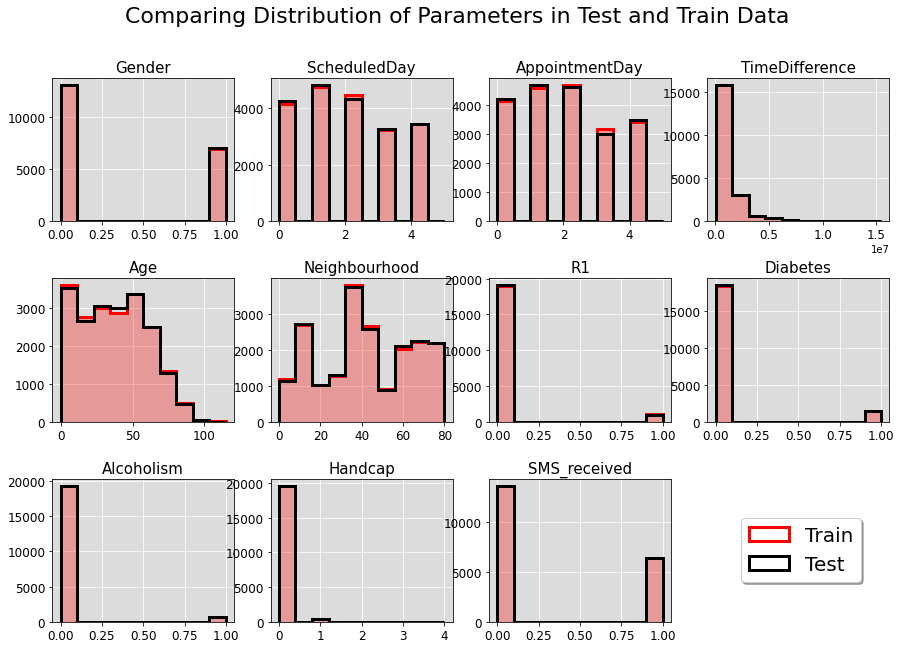

In [6]:
# Show 1D distributions
fig, ax = plt.subplots(nrows=3, ncols=4, gridspec_kw={'wspace':0.2, 'hspace':0.4}, figsize=(15,10))
fig.delaxes(ax[2,3])
ax = ax.flatten()

# Loop over features
for i in range(len(features_to_train)):
    
    ax[i].set_title(features_to_train[i], fontsize=15)
    ax[i].set_facecolor('gainsboro')
    ax[i].grid(color='white')
    ax[i].tick_params(axis="x", labelsize=12) 
    ax[i].tick_params(axis="y", labelsize=12) 
    
    _, bins_arr, _ = ax[i].hist(train_data[features_to_train[i]], bins=10, zorder=2,
                                histtype='step', linewidth=3, color='r', label='Train')
    ax[i].hist(train_data[features_to_train[i]], bins=10, alpha=0.3, linewidth=3, color='r',zorder=2)
    
    ax[i].hist(test_data[features_to_train[i]], bins=bins_arr, zorder=2,
               histtype='step', linewidth=3, color='k', label='Test')
    
ax[10].legend(loc='center right', bbox_to_anchor=(2.1, 0.5), fancybox=True, shadow=True, fontsize=20)

fig.suptitle('Comparing Distribution of Parameters in Test and Train Data', fontsize=22)

if SavePlots:
    plt.tight_layout()
    plt.savefig('Plots/4_1.pdf')

plt.show()

Train and test look pretty similar, nice.

# Split into X and Y and Transform Data

In [8]:
# X contains out parameters - shape (n_samples, n_features)
X_train = train_data[features_to_train]
X_test = test_data[features_to_train]

# Y contains the truth - shape (n_samples)
Y_train = train_data['No-show']
Y_test = test_data['No-show']

# Scale the data to similar sizes (RobustScalar or QuantileTransformer)
qt = QuantileTransformer(n_quantiles=1000, random_state=0)
Xt_train = qt.fit_transform(X_train)
Xt_test = qt.fit_transform(X_train)

# Hyper Parameter Optimization

In [15]:
##### The main parameters are max_depth and n_estimators so lets make a gridsearch of variations those

# Define model
model_temp = MLPClassifier(max_iter=20000,
                           n_iter_no_change=100,       # Number of iters without improvement before stopping
                           solver='adam',              # Standard for minimising
                           activation='logistic',      # Standard function (but slightly slower)
                           learning_rate='invscaling', # Other options are "constant" and "adaptive"
                           random_state=42)

# Specify parameters and distributions to sample from
# Hidden layer size = size of network, len is number of layers and the elements number of neurons in layer
parameters_GridSearch = {'hidden_layer_sizes': [(5,2), (10,10), (5,5,5), (10,5,2)]}

# Chose number of iterations and number of folds
k = 5

GridSearch = GridSearchCV(model_temp, 
                          param_grid=parameters_GridSearch, 
                          cv=k, 
                          return_train_score=True,
                          scoring = 'accuracy')

# Fit the random search instance
GridSearch.fit(Xt_train, Y_train);

# Get results
GridSearch_results = pd.DataFrame(GridSearch.cv_results_)                 
print("Grid Search: \tBest parameters: ", GridSearch.best_params_, f", Best scores: {GridSearch.best_score_:.3f}")

GridSearch_results.head(3)

Grid Search: 	Best parameters:  {'hidden_layer_sizes': (5, 5, 5)} , Best scores: 0.817


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_hidden_layer_sizes,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,9.973412,0.617644,0.006073,0.009552,"(5, 2)","{'hidden_layer_sizes': (5, 2)}",0.82275,0.81475,0.82000,0.8110,...,0.81670,0.004164,3,0.815875,0.817312,0.816312,0.818375,0.817312,0.817037,0.000874
1,13.965108,2.666133,0.001817,0.000116,"(10, 10)","{'hidden_layer_sizes': (10, 10)}",0.82100,0.81525,0.81975,0.8110,...,0.81645,0.003583,4,0.816000,0.817375,0.816125,0.818438,0.817625,0.817113,0.000927
2,16.410887,3.243406,0.002061,0.000324,"(5, 5, 5)","{'hidden_layer_sizes': (5, 5, 5)}",0.82225,0.81550,0.81950,0.8125,...,0.81690,0.003502,1,0.815875,0.817250,0.816438,0.818438,0.817625,0.817125,0.000897


In [16]:
# Set the hyperparameters found
layers_GS = GridSearch.best_params_['hidden_layer_sizes']
print('We use hidden layer size:', layers_GS)

We use hidden layer size: (5, 5, 5)


# Classifier

In [17]:
# Define model
model = MLPClassifier(max_iter=20000,
                      n_iter_no_change=100,       # Number of iters without improvement before stopping
                      solver='adam',              # Standard for minimising
                      activation='logistic',      # Standard function (but slightly slower)
                      learning_rate='invscaling', # Other options are "constant" and "adaptive"
                      random_state=42,
                      hidden_layer_sizes=layers_GS)

# Train model
model.fit(Xt_train, Y_train)

# Calculate accuracy on train
Y_pred_train = model.predict(Xt_train)
accuracy_train = accuracy_score(Y_train, Y_pred_train)
print('Accuracy on Train:', accuracy_train)

# Calculate accuracy on test
Y_pred_test = model.predict(Xt_test)
accuracy_test = accuracy_score(Y_test, Y_pred_test)
print('Accuracy on Test:', accuracy_test)

# Get predictions
# a numpy array of shape array-like of shape (n_samples, n_classes) 
# with the probability of each data example being of a given class.

# Train
predictions_train = model.predict_proba(Xt_train) 
predictions_train = pd.DataFrame(predictions_train, columns=['Show', 'No-show'])

# Test
predictions_test = model.predict_proba(Xt_test) 
predictions_test = pd.DataFrame(predictions_test, columns=['Show', 'No-show'])

Accuracy on Train: 0.81685
Accuracy on Test: 0.77625


## ROC curve

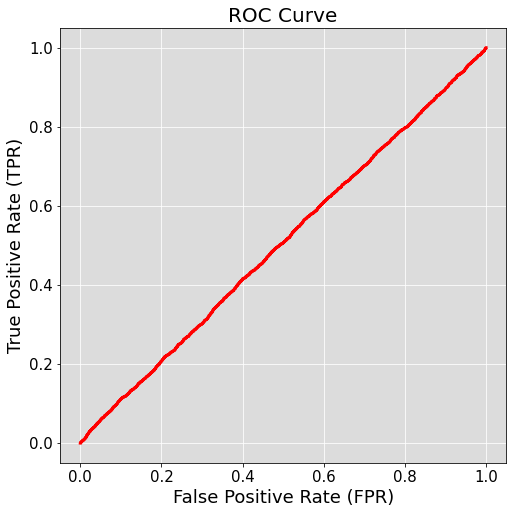

In [18]:
# Get fpr and tpr to produce roc_curve
fpr, tpr, _ = roc_curve(Y_test, predictions_test['No-show'])
auc_score = auc(fpr, tpr)

# Plot it
fig, ax = plt.subplots(figsize=(8,8))
ax.plot(fpr, tpr, color='r', linewidth=3)

ax.set_facecolor('gainsboro')
ax.grid(color='white')

ax.set_xlabel('False Positive Rate (FPR)', fontsize=18)
ax.set_ylabel('True Positive Rate (TPR)', fontsize=18)
ax.set_title('ROC Curve', fontsize=20)

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.show()

# 4A Solution Plot

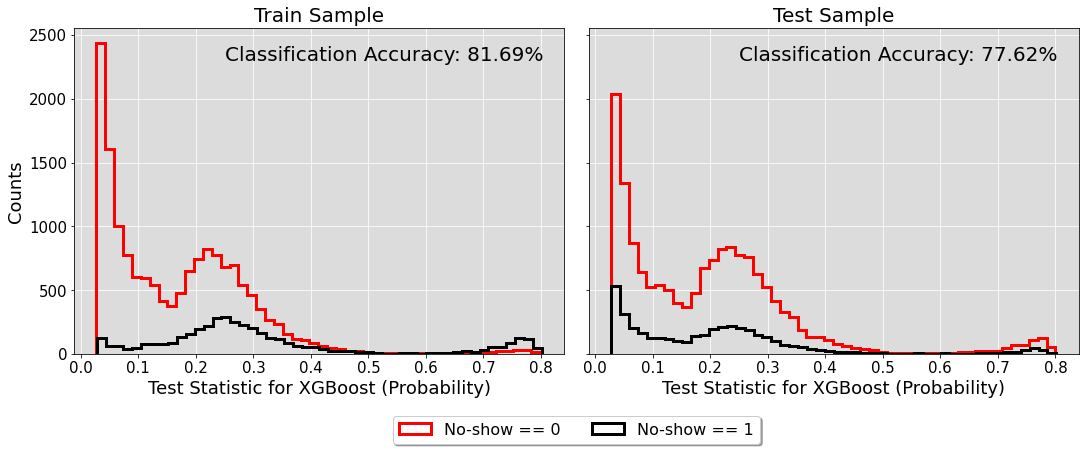

In [20]:
# Create test statistic plot
fig, ax = plt.subplots(ncols=2, figsize=(18,6), sharey=True, gridspec_kw={'wspace':0.05})

# Train sample ---------
ax[0].hist(predictions_train['No-show'][Y_train==0], color='r', histtype='step', 
           bins=50, linewidth=3, label='No-show == 0')
ax[0].hist(predictions_train['No-show'][Y_train==1], color='k', histtype='step', 
           bins=50, linewidth=3, label='No-show == 1')

# Write accuracy
ax[0].text(0.25, 2300, f'Classification Accuracy: {accuracy_train*100:.2f}%', fontsize=20)

ax[0].tick_params(axis="x", labelsize=15) 
ax[0].tick_params(axis="y", labelsize=15) 
ax[0].set_ylabel('Counts', fontsize=18)
ax[0].set_xlabel('Test Statistic for XGBoost (Probability)', fontsize=18)
ax[0].set_title('Train Sample', fontsize=20)

ax[0].set_facecolor('gainsboro')
ax[0].grid(color='white')

# Test sample ---------
ax[1].hist(predictions_test['No-show'][Y_test==0], color='r', histtype='step', 
           bins=50, linewidth=3, label='No-show == 0')
ax[1].hist(predictions_test['No-show'][Y_test==1], color='k', histtype='step', 
           bins=50, linewidth=3, label='No-show == 1')

# Write accuracy
ax[1].text(0.25, 2300, f'Classification Accuracy: {accuracy_test*100:.2f}%', fontsize=20)

ax[1].set_facecolor('gainsboro')
ax[1].grid(color='white')


# Pretty
ax[1].legend(loc='lower center', prop={'size':16}, bbox_to_anchor=(-0.025, -0.3),
          ncol=3, fancybox=True, shadow=True)

ax[1].tick_params(axis="x", labelsize=15) 
ax[1].set_xlabel('Test Statistic for XGBoost (Probability)', fontsize=18)
ax[1].set_title('Test Sample', fontsize=20)

plt.show()

# Problem (4B)

In [107]:
model.feature_importances_

array([0.02748342, 0.0475508 , 0.0346735 , 0.05610883, 0.17927183,
       0.03245684, 0.01832965, 0.03573308, 0.04007029, 0.04445667,
       0.48386502], dtype=float32)

In [108]:
features_to_train

['Gender',
 'ScheduledDay',
 'AppointmentDay',
 'TimeDifference',
 'Age',
 'Neighbourhood',
 'R1',
 'Diabetes',
 'Alcoholism',
 'Handcap',
 'SMS_received']

## Repeat the same, but only with best 6 features now

In [109]:
## Same model as before, but lets remove some of the worst features
best_features = ['ScheduledDay', 'TimeDifference','Age','Alcoholism','Handcap','SMS_received']

# X contains out parameters - shape (n_samples, n_features)
X2_train = train_data[best_features]
X2_test = test_data[best_features]

# Y contains the truth - shape (n_samples)
Y2_train = train_data['No-show']
Y2_test = test_data['No-show']

In [110]:
# Define model
model2 = XGBClassifier(objective='binary:logistic', eval_metric='logloss', random_state=1,
                      learning_rate=0.1, use_label_encoder=False, n_estimators=n_estimators_GS, 
                      max_depth=max_depth_GS)

# Train model
model2.fit(X2_train, Y2_train)

# Calculate accuracy on train
Y2_pred_train = model2.predict(X2_train)
accuracy2_train = accuracy_score(Y2_train, Y2_pred_train)
print('Accuracy on Train:', accuracy2_train)

# Calculate accuracy on test
Y2_pred_test = model2.predict(X2_test)
accuracy2_test = accuracy_score(Y2_test, Y2_pred_test)
print('Accuracy on Test:', accuracy_test)

# Get predictions
# a numpy array of shape array-like of shape (n_samples, n_classes) 
# with the probability of each data example being of a given class.

# Train
predictions2_train = model2.predict_proba(X2_train) 
predictions2_train = pd.DataFrame(predictions2_train, columns=['Show', 'No-show'])

# Test
predictions2_test = model2.predict_proba(X2_test) 
predictions2_test = pd.DataFrame(predictions2_test, columns=['Show', 'No-show'])

Accuracy on Train: 0.8
Accuracy on Test: 0.81545


it did not get better :(